## Preliminaries

In [1]:
import numpy as np
import torch
import pickle
from tqdm import tqdm
from joblib import Parallel, delayed
from pyro.distributions.empirical import Empirical

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis

# distances
from scipy.spatial.distance import directed_hausdorff

In [2]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Simulator

In [3]:
from HH_helper_functions import syn_current

I, t_on, t_off, dt, t, A_soma = syn_current()

In [4]:
from HH_helper_functions import HHsimulator

In [5]:
def run_HH_model(params):

    params = np.asarray(params)
    
    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    # initial voltage
    V0 = -70
    
    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [6]:
# three sets of (g_Na, g_K)
params = np.array([[50., 1.],[4., 1.5],[20., 15.]])

num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i,:] = run_HH_model(params=params[i,:])['data']

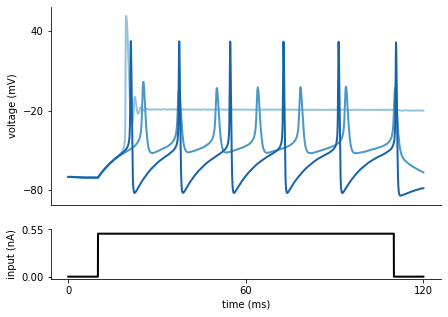

In [7]:
# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.show()

In [8]:
from HH_helper_functions import calculate_summary_statistics

In [9]:
def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [10]:
true_params = np.array([50., 5.])
labels_params = [r'$g_{Na}$', r'$g_{K}$']
observation_trace = run_HH_model(true_params)
observation_summary_statistics = calculate_summary_statistics(observation_trace)

In [11]:
prior_min = [.5,1e-4]
prior_max = [80.,15.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Distance functions

In [12]:
def euclidean(x,y):
    #return torch.linalg.norm(x-y)
    x = torch.tensor(x['data'])
    y = torch.tensor(y['data'])
    return torch.linalg.norm(x-y)

def simulation_wrapper_euclidean(params):
    """
    Uses euclidean distances from a given observation as summary
    """
    obs = observation_trace
    data = run_HH_model(params)
    summstats = euclidean(data,obs)
    return torch.as_tensor([summstats])

In [13]:
def hausdorff_dist(x,y, reverse = False):
    x_pairs = np.array([x['time'],x['data']]).T
    y_pairs = np.array([y['time'],y['data']]).T
    if reverse:
        return directed_hausdorff(y_pairs,x_pairs)
    return directed_hausdorff(x_pairs,y_pairs)
    # x_pairs = torch.vstack([x['time'],x['data']])


In [14]:
def simulation_wrapper_hausdorff(params, reverse=False):
    obs = observation_trace
    data = run_HH_model(params)
    summstats = hausdorff_dist(data,obs, reverse)
    return torch.as_tensor([summstats[0]])

## Summary comparisons (their summaries on our results)
The summary features, in order, are the number of spikes, the mean resting potential, the standard deviation of the resting potential, and the first four voltage moments: mean, standard deviation, skewness and kurtosis

In [235]:
their_posterior = infer(simulation_wrapper, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)
euclidean_posterior = infer(simulation_wrapper_euclidean, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)
hausdorff_posterior = infer(simulation_wrapper_hausdorff, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 103 epochs.

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 115 epochs.

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 230 epochs.

In [239]:
their_samples = their_posterior.sample((1000,),x=observation_summary_statistics)
euclidean_samples = euclidean_posterior.sample((1000,),x=torch.tensor([0]))
hausdorff_samples = hausdorff_posterior.sample((1000,),x=torch.tensor([0]))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [238]:
def summaries_for_plots(their_samples, euclidean_samples, hausdorff_samples):
    all_summs = np.array([simulation_wrapper(sample).numpy() for sample in tqdm(their_samples)])
    all_summs_e = np.array([simulation_wrapper(sample).numpy() for sample in tqdm(euclidean_samples)])
    all_summs_h = np.array([simulation_wrapper(sample).numpy() for sample in tqdm(hausdorff_samples)])
    # all_summs=Parallel(n_jobs=7, verbose=10)(simulation_wrapper(sample) for sample in samples)
    # all_summs=np.array([summaries.numpy() for summaries in all_sums])
    return all_summs, all_summs_e, all_summs_h

In [240]:
all_summs, all_summs_e, all_summs_h =summaries_for_plots(their_samples, euclidean_samples, hausdorff_samples)

100%|██████████| 1000/1000 [20:31<00:00,  1.23s/it]


In [284]:
sums_join = all_summs, all_summs_e, all_summs_h

In [285]:
with open('summary_saved.pkl', 'wb') as f:
    pickle.dump(sums_join, f)

In [264]:
def MSE(samples, true_params):
    samples = torch.tensor(samples)
    true_params = torch.tensor(true_params)
    loss = torch.nn.MSELoss()
    return loss(samples, true_params)

In [288]:
def plot_from_summaries(all_summs, all_summs_e, all_summs_h, x):
    # all_summs=Parallel(n_jobs=7, verbose=10)(simulation_wrapper(sample) for sample in samples)
    # all_summs=np.array([summaries.numpy() for summaries in all_sums])
    plt_titles = ['n_spike', 'rp_mean', 'rp_std','mom_1','mom_2','mom_3','mom_4']
    for i in range(7):
        all_summs_combined = np.concatenate([all_summs, all_summs_e, all_summs_h])
        bins_min = min(all_summs_combined[:,i])
        bins_max = max(all_summs_combined[:,i])
        bins = np.linspace(bins_min,bins_max,50)
        plt.hist(all_summs[:,i],bins=bins,alpha=0.5)
        plt.hist(all_summs_e[:,i],bins=bins,alpha=0.5)
        plt.hist(all_summs_h[:,i],bins=bins,alpha=0.5)
        plt.title(plt_titles[i])
        plt.axvline(x[i])
        plt.figure()

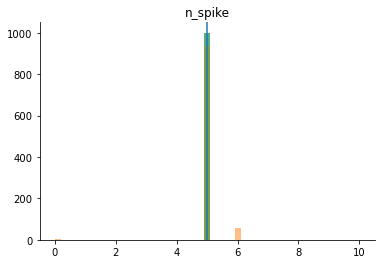

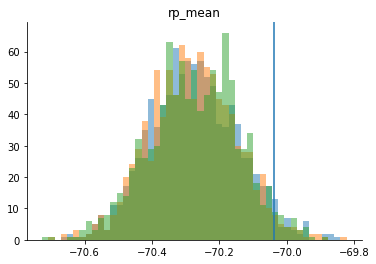

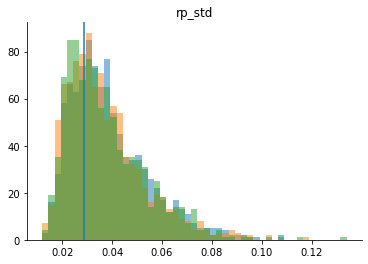

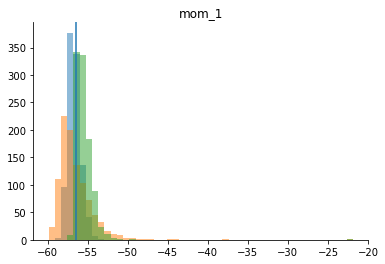

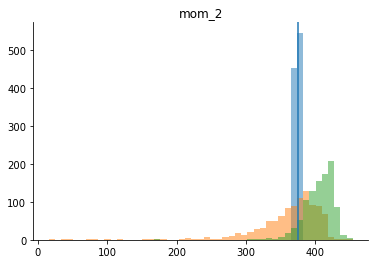

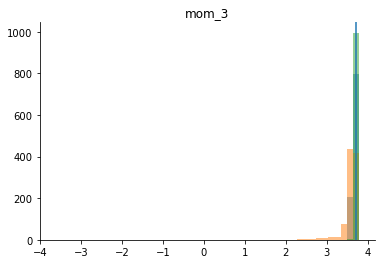

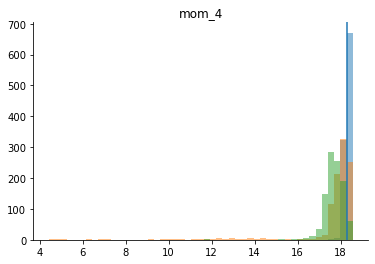

<Figure size 432x288 with 0 Axes>

In [289]:
plot_from_summaries(all_summs,all_summs_e, all_summs_h, observation_summary_statistics)

In [303]:
def MSE_plots(all_summs, all_summs_e, all_summs_h,x):
    
    def MSE_vector(summs):
        return np.array([MSE(summs[:,i],x[i]) for i in range(7)])

    
    plt_labels = ['n_spike', 'rp_mean', 'rp_std','mom_1','mom_2','mom_3','mom_4']
    label_loc = np.arange(len(plt_labels))
    width = 0.2

    their_MSE_norm = np.ones((7,))
    MSE_e_norm = MSE_vector(all_summs_e)/MSE_vector(all_summs)
    MSE_h_norm = MSE_vector(all_summs_h)/MSE_vector(all_summs)

    plt.bar(label_loc-0.2, their_MSE_norm, width, color='cyan')
    plt.bar(label_loc, MSE_e_norm, width, color='orange')
    plt.bar(label_loc+0.2, MSE_h_norm, width, color='green')
    plt.xticks(label_loc, plt_labels)
    plt.legend(["Their Posterior", "Euclidean", "Hausdorff"])
    plt.show()


/home/sragy/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/tmp/ipykernel_12152/1222410988.py:12: RuntimeWarning: divide by zero encountered in true_divide
  MSE_e_norm = MSE_vector(all_summs_e)/MSE_vector(all_summs)
/tmp/ipykernel_12152/1222410988.py:13: RuntimeWarning: divide by zero encountered in true_divide
  MSE_h_norm = MSE_vector(all_summs_h)/MSE_vector(all_summs)


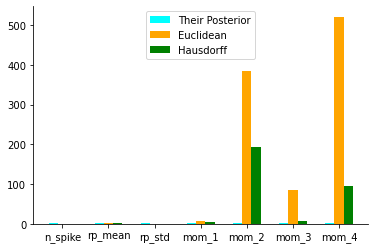

In [304]:
MSE_plots(all_summs, all_summs_e, all_summs_h,observation_summary_statistics)

In [302]:
np.array([MSE(all_summs_h[:,i],observation_summary_statistics[i]) for i in range(7)])/np.array([MSE(all_summs[:,i],observation_summary_statistics[i]) for i in range(7)])

/home/sragy/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/tmp/ipykernel_12152/239531856.py:1: RuntimeWarning: divide by zero encountered in true_divide
  np.array([MSE(all_summs_h[:,i],observation_summary_statistics[i]) for i in range(7)])/np.array([MSE(all_summs[:,i],observation_summary_statistics[i]) for i in range(7)])


array([         inf,   0.99329969,   0.95810841,   4.38901225,
       193.47418866,   7.91608325,  96.30442611])

## Why are even moments so bad?

In [ ]:
with open('summary_saved.pkl', 'rb') as f:
    summary_tuple = pickle.load(f)

## Multiple-rounds, disks, reducing the median distance

In [305]:
def simulation_wrapper_hausdorff_disk(radius):
    
    def simulation_wrapper_interior(params):
        data = observation_trace
        obs = run_HH_model(params)
        summstats = hausdorff_dist(data,obs)[0]
        max_dist = max(summstats, radius)
        return torch.as_tensor([max_dist])

    return simulation_wrapper_interior

def simulation_wrapper_euclidean_disk(radius):
    
    def simulation_wrapper_interior(params):
        data = observation_trace
        obs = run_HH_model(params)
        def euclidean(x,y):
            return np.linalg.norm(x-y)
        summstats = euclidean(data,obs)
        max_dist = max(summstats, radius)
        return torch.as_tensor([max_dist])

    return simulation_wrapper_interior

In [313]:
def find_quantile(xs,quant):
    return np.quantile(xs.numpy(),quant)

tensor([18.9146], dtype=torch.float64)

In [316]:
# Intialise quantile

simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_disk(0), prior)
theta, x = simulate_for_sbi(simulator, prior, num_simulations=200, num_workers=7)
x_o = find_quantile(x,0.33)

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 238 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

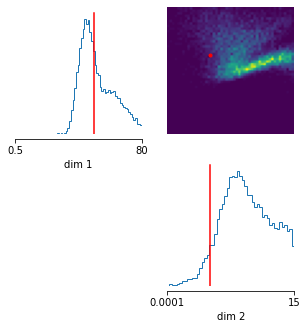

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

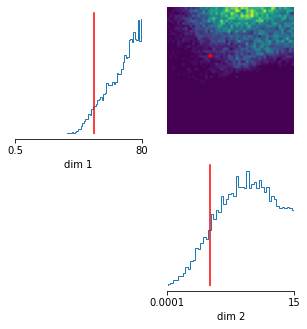

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

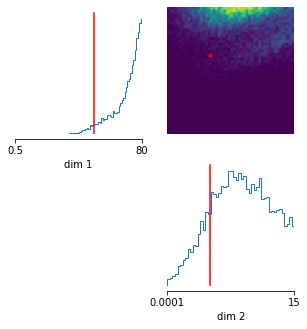

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

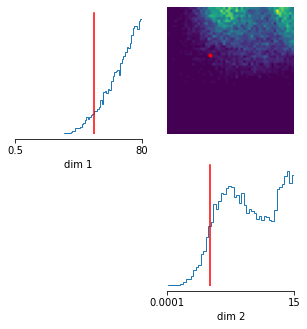

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 92 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

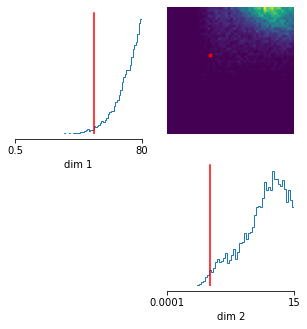

In [320]:
num_rounds = 5
posteriors = []
x_o_seq = [x_o]
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_disk(x_o), prior)
quant_simulator, _ = prepare_for_sbi(simulation_wrapper_hausdorff_disk(0), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    _, x_quant = simulate_for_sbi(quant_simulator, proposal, num_simulations=200, num_workers=7)
    x_o = find_quantile(x_quant,0.33)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    x_o_seq.append(x_o)
    proposal = posterior.set_default_x(torch.tensor([x_o]))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Now, create a new inference object every time. The results may get a bit garbled in earlier examples by the fact that we're changing the summaries each time

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 205 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

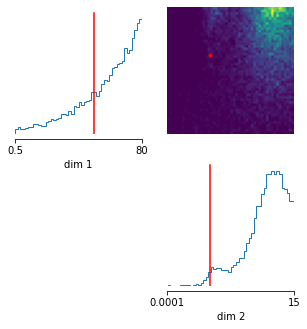

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 102 epochs.ral network. Epochs trained: 85

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

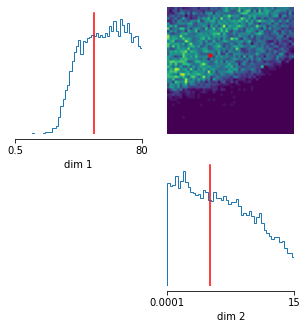

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

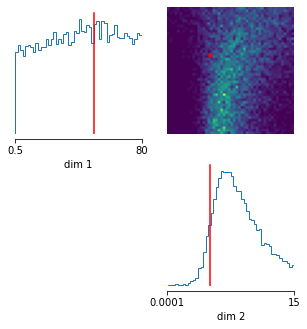

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 146 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

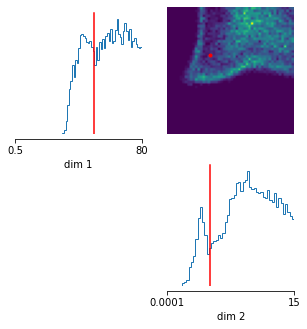

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

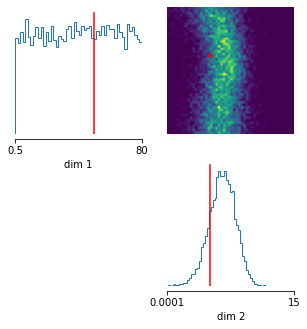

In [324]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_disk(x_o), prior)
quant_simulator, _ = prepare_for_sbi(simulation_wrapper_hausdorff_disk(0), prior)
proposal = prior

_, x_quant = simulate_for_sbi(quant_simulator, prior, num_simulations=200, num_workers=7)
x_o = find_quantile(x,0.33)
x_o_seq = [x_o]


for i in range(num_rounds):
    inference = SNPE(prior=prior)
    simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_disk(x_o), prior)
    quant_simulator, _ = prepare_for_sbi(simulation_wrapper_hausdorff_disk(0), prior)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    _, x_quant = simulate_for_sbi(quant_simulator, proposal, num_simulations=200, num_workers=7)
    x_o = find_quantile(x_quant,0.33)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    x_o_seq.append(x_o)
    proposal = posterior.set_default_x(torch.tensor([x_o]))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 90 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

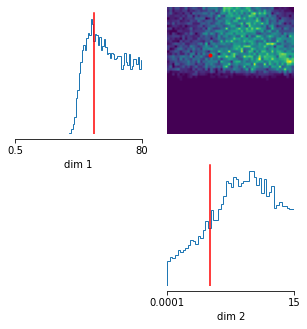

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 122 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

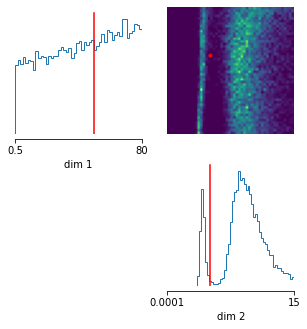

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 104 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9984 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


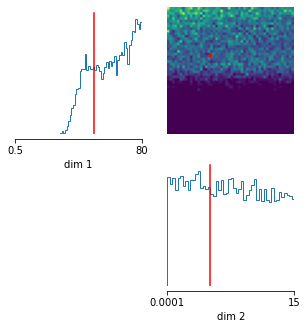

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 175 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 187 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 9939 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


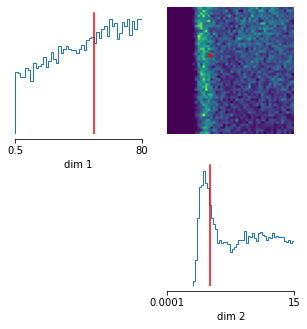

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 127 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

                        prior support. It may take a long time to collect the
                        remaining 137 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 105 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

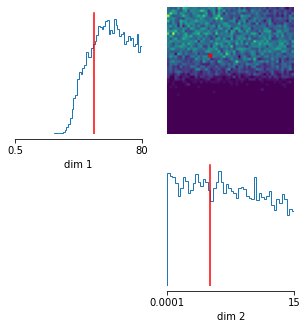

In [325]:
for i in range(num_rounds):
    inference = SNPE(prior=prior)
    simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_disk(x_o), prior)
    quant_simulator, _ = prepare_for_sbi(simulation_wrapper_hausdorff_disk(0), prior)
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    _, x_quant = simulate_for_sbi(quant_simulator, proposal, num_simulations=200, num_workers=7)
    x_o = find_quantile(x_quant,0.33)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    x_o_seq.append(x_o)
    proposal = posterior.set_default_x(torch.tensor([x_o]))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

## Piece-wise distances

In [17]:
def simulation_wrapper_hausdorff_split(split=7):
    def sim_wrapped(params):
        obs = observation_trace
        data = run_HH_model(params)

        x_pairs = np.array([obs['time'],obs['data']]).T
        y_pairs = np.array([data['time'],data['data']]).T

        x_pairs_split = np.array_split(x_pairs,split)
        y_pairs_split = np.array_split(y_pairs,split)

        summstats = []
        for i in range(split):
            summstats.append(directed_hausdorff(x_pairs_split[i],y_pairs_split[i])[0])
        
        return torch.as_tensor(summstats)
    
    return sim_wrapped

In [334]:
hausdorff7_posterior = infer(simulation_wrapper_hausdorff_split, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 262 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

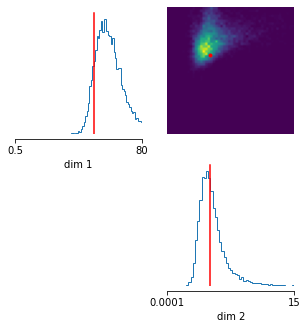

In [336]:
samples=hausdorff7_posterior.sample((10000,),x = torch.zeros(7))
fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [350]:
hausdorff50_posterior = infer(simulation_wrapper_hausdorff_split(50), prior, method='SNPE', num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 76 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

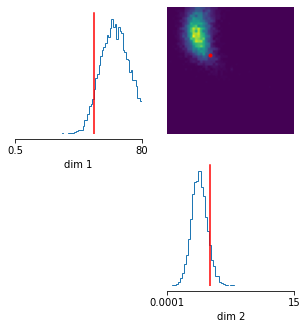

In [353]:
samples=hausdorff50_posterior.sample((10000,),x = torch.zeros(50))
fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [18]:
def sim_wrap_hauss_disk_split(radius=1, split=7):

    def sim_wrap_hauss(params):
        obs = observation_trace
        data = run_HH_model(params)

        x_pairs = np.array([obs['time'],obs['data']]).T
        y_pairs = np.array([data['time'],data['data']]).T

        x_pairs_split = np.array_split(x_pairs,split)
        y_pairs_split = np.array_split(y_pairs,split)

        summstats = []
        for i in range(split):
            summstats.append(directed_hausdorff(x_pairs_split[i],y_pairs_split[i])[0])
        

        summstats = np.maximum(summstats, np.full((split,),radius))
        
        return torch.as_tensor(summstats)
    
    return sim_wrap_hauss

In [346]:
hausdorff7_posterior1 = infer(sim_wrap_hauss_disk_split(), prior, method='SNPE', num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 251 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

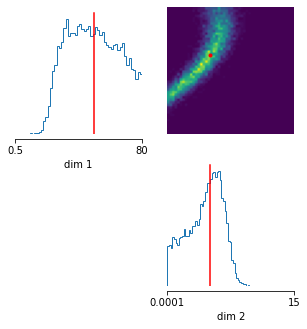

In [349]:
samples=hausdorff7_posterior1.sample((10000,),x = torch.ones(7))
fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [19]:
def simulation_wrapper_euclid_split(split=7):
    
    def euclidean(x,y):
        return np.linalg.norm(x-y)
    
    def sim_wrapped(params):
        data = run_HH_model(params)['data']
        obs = observation_trace['data']
        data_split = np.array_split(data,split)
        obs_split = np.array_split(obs,split)
        summstats = []
        for i in range(split):
            summstats.append(euclidean(data_split[i],obs_split[i]))
        return torch.tensor(summstats)
    
    return sim_wrapped

In [374]:
euclid7_posterior = infer(simulation_wrapper_euclid_split(), prior, method='SNPE', num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 145 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

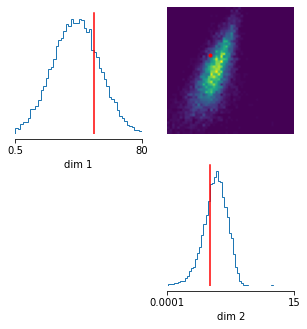

In [375]:
samples=euclid7_posterior.sample((10000,), x = torch.zeros(7))
fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [376]:
euclid50_posterior = infer(simulation_wrapper_euclid_split(50), prior, method='SNPE', num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 71 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

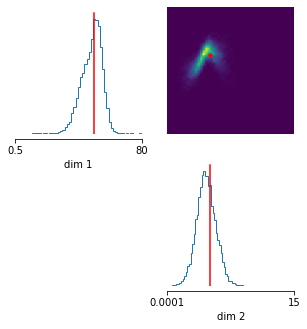

In [384]:
samples=euclid50_posterior.sample((10000,), x = torch.zeros(50))
fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

In [390]:
euclid100_posterior = infer(simulation_wrapper_euclid_split(100), prior, method='SNPE', num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 43 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

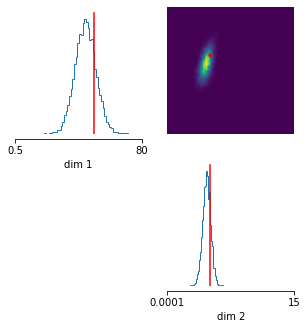

In [391]:
samples=euclid100_posterior.sample((10000,), x = torch.zeros(100))
fig, axes = analysis.pairplot(samples,
                           limits=[[.5,80], [1e-4,15.]],
                           ticks=[[.5,80], [1e-4,15.]],
                           figsize=(5,5),
                           points=true_params,
                           points_offdiag={'markersize': 6},
                           points_colors='r');

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

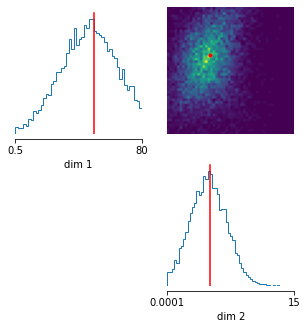

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 85 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

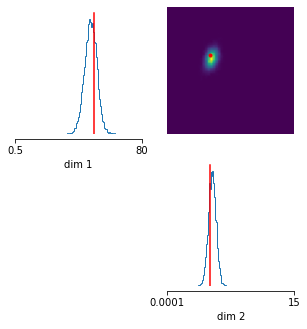

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 26 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

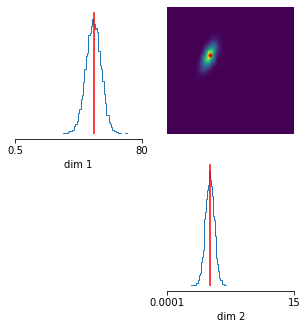

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

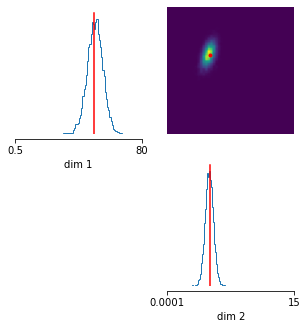

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

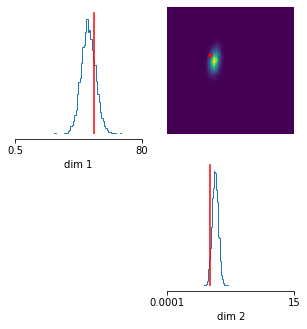

In [393]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(simulation_wrapper_euclid_split(100), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(torch.zeros(100))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 63 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

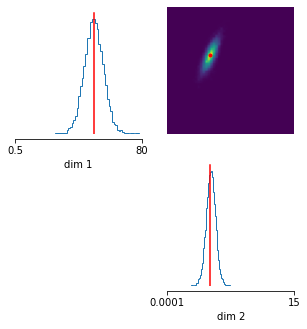

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 62 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

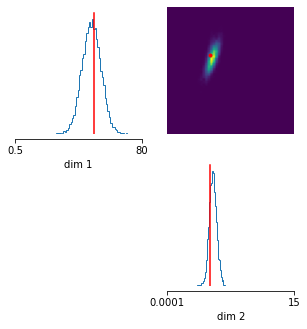

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 46 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

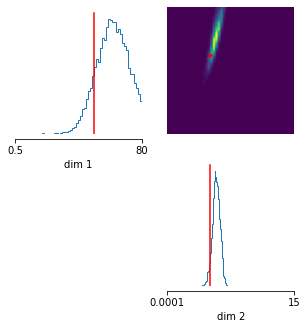

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

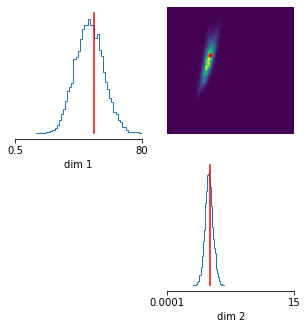

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 33 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

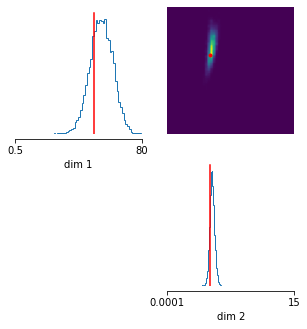

In [404]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(simulation_wrapper_euclid_split(120), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(torch.zeros(120))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

In [406]:
round_1_samples = posteriors[0].sample((1000,),x=torch.zeros(120))
round_5_samples = posteriors[-1].sample((1000,),x=torch.zeros(120))
all_summs_1 = np.array([simulation_wrapper(sample).numpy() for sample in tqdm(round_1_samples)])
all_summs_5 = np.array([simulation_wrapper(sample).numpy() for sample in tqdm(round_5_samples)])

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [46:58<00:00,  2.82s/it] 


/home/sragy/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/tmp/ipykernel_12152/1869347772.py:12: RuntimeWarning: invalid value encountered in true_divide
  MSE_e_norm = MSE_vector(all_summs_e)/MSE_vector(all_summs)
/tmp/ipykernel_12152/1869347772.py:13: RuntimeWarning: invalid value encountered in true_divide
  MSE_h_norm = MSE_vector(all_summs_h)/MSE_vector(all_summs)


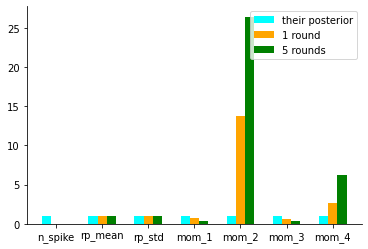

In [409]:
def MSE_plots(all_summs, all_summs_e, all_summs_h,legends,x):
    
    def MSE_vector(summs):
        return np.array([MSE(summs[:,i],x[i]) for i in range(7)])

    
    plt_labels = ['n_spike', 'rp_mean', 'rp_std','mom_1','mom_2','mom_3','mom_4']
    label_loc = np.arange(len(plt_labels))
    width = 0.2

    their_MSE_norm = np.ones((7,))
    MSE_e_norm = MSE_vector(all_summs_e)/MSE_vector(all_summs)
    MSE_h_norm = MSE_vector(all_summs_h)/MSE_vector(all_summs)

    plt.bar(label_loc-0.2, their_MSE_norm, width, color='cyan')
    plt.bar(label_loc, MSE_e_norm, width, color='orange')
    plt.bar(label_loc+0.2, MSE_h_norm, width, color='green')
    plt.xticks(label_loc, plt_labels)
    plt.legend(legends)
    plt.show()

legends = ["their posterior", "1 round", "5 rounds"]
MSE_plots(all_summs, all_summs_1, all_summs_5,legends,observation_summary_statistics)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 205 epochs.ural network. Epochs trained: 149

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

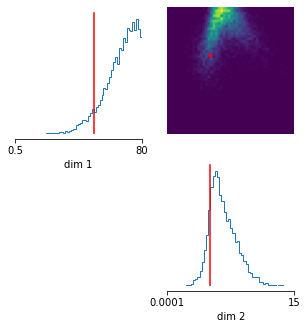

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 161 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

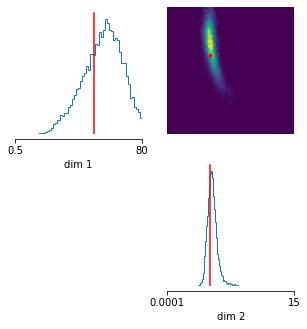

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 96 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

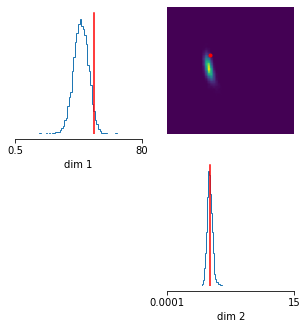

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 59 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

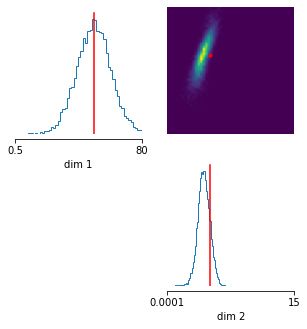

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 39 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

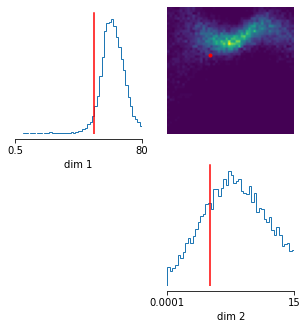

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 41 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

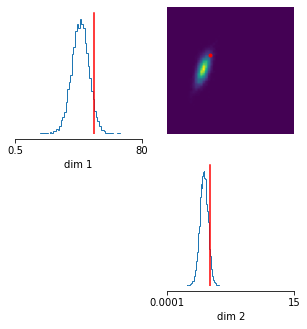

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 36 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

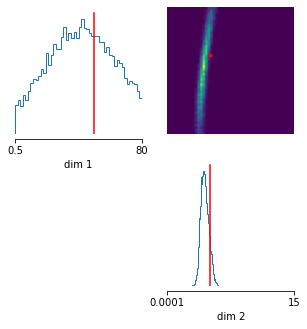

In [57]:
bins = [1,10,20,40,80,160,320]
for i in bins:
    our_posterior = infer(simulation_wrapper_euclid_split(i), prior, method='SNPE', 
                    num_simulations=300, num_workers=4)
    samples = our_posterior.sample((10000,),x=torch.zeros(i))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 140 epochs.ral network. Epochs trained: 22Training neural network. Epochs trained: 36

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

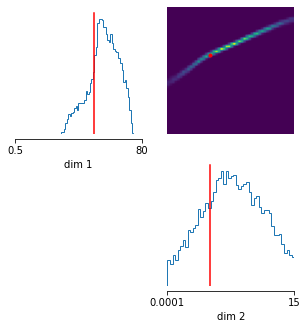

In [58]:
their_posterior = infer(simulation_wrapper, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)
samples = their_posterior.sample((10000,),x=observation_summary_statistics)
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 120 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

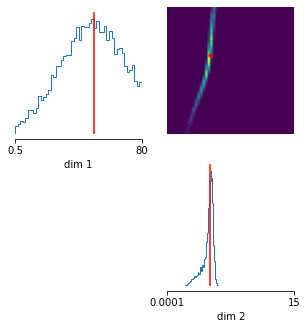

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 337 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

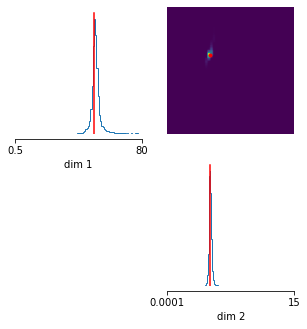

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 169 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

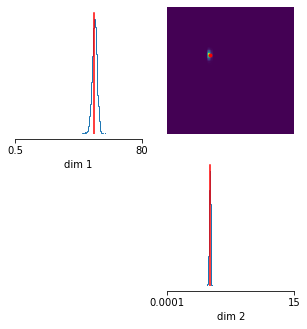

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 261 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

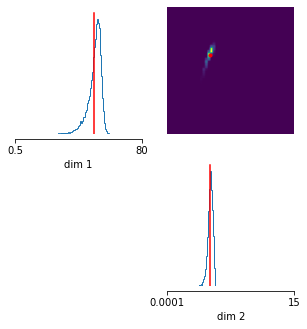

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 155 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

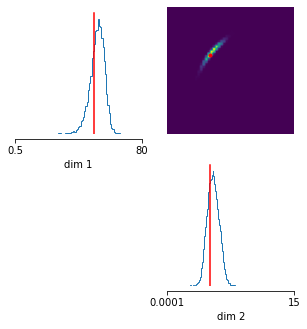

In [59]:
for i in range(5):

    their_posterior = infer(simulation_wrapper, prior, method='SNPE', 
                    num_simulations=300, num_workers=4)
    samples = their_posterior.sample((10000,),x=observation_summary_statistics)
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

# Use Calibration Kernels

In [126]:
def filter_kernel(quant,xs):

    xs=xs.sum(axis=1)
    quantile = np.quantile(xs,quant)
    
    def wrapped(x):

        return (x.sum(axis=1) < quantile).float()

    return wrapped

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 60 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

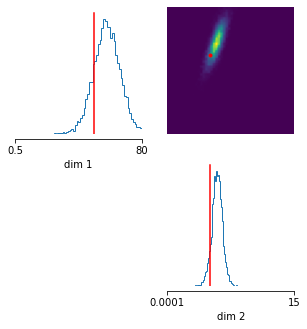

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 75 epochs.ural network. Epochs trained: 35

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

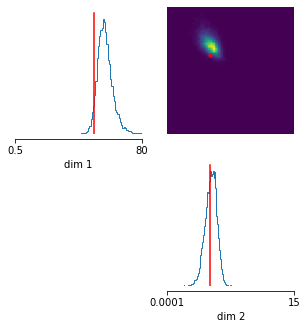

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

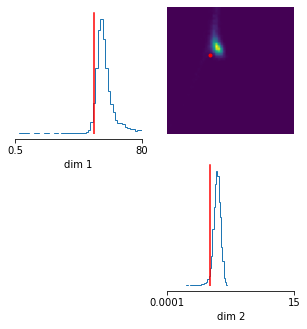

In [127]:
num_rounds = 3
posteriors = []
simulator, prior = prepare_for_sbi(simulation_wrapper_euclid_split(120), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(calibration_kernel=filter_kernel(0.5,inference.get_simulations()[1]))
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(torch.zeros(120))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

## Kernels STDev

In [113]:
def kernel_std(xs):
    distances = xs.sum(axis=1)
    var = torch.var(distances)
    return torch.exp(-0.5*xs.sum(axis=1)**2/(var))


def kernel_std_2(xs): # Handles things correctly because of how batches are passed
    
    distances = xs.sum(axis=1)
    var = torch.var(distances)

    def wrapped(x):
        return torch.exp(-0.5*x.sum(axis=1)**2/(var))
    
    return wrapped





Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 67 epochs.ural network. Epochs trained: 62

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

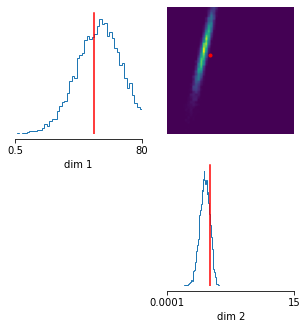

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

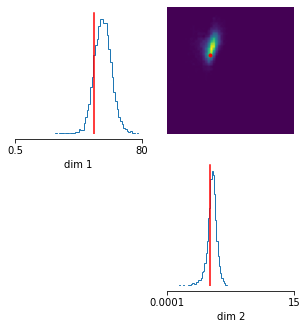

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

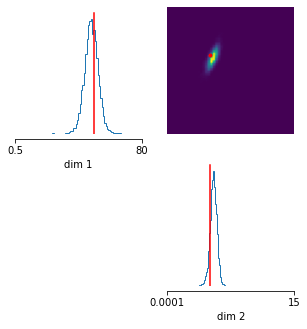

In [110]:
num_rounds = 3
posteriors = []
simulator, prior = prepare_for_sbi(simulation_wrapper_euclid_split(120), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(calibration_kernel=kernel_std)
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(torch.zeros(120))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

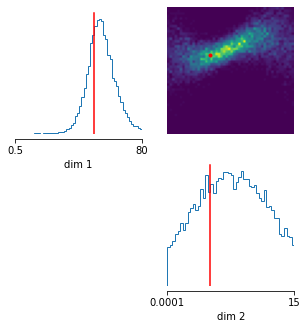

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

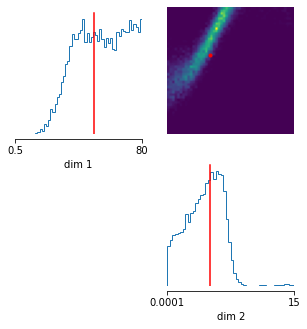

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 80 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

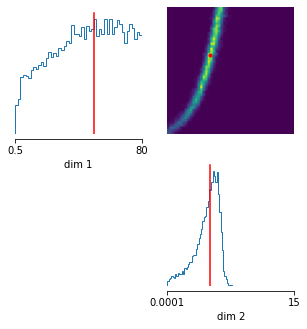

In [111]:
num_rounds = 3
posteriors = []
simulator, prior = prepare_for_sbi(simulation_wrapper_euclid_split(120), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(torch.zeros(120))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 44 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

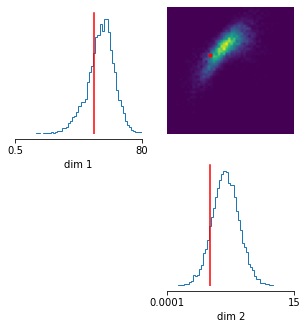

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 66 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

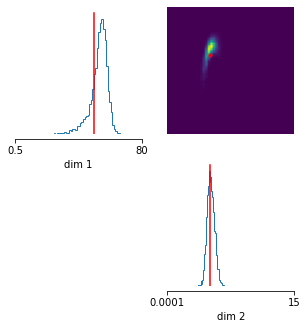

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

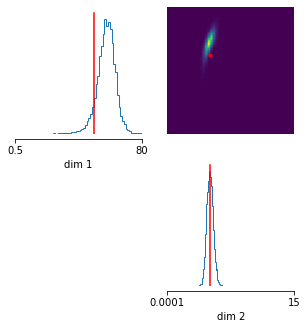

In [115]:
num_rounds = 3
posteriors = []
simulator, prior = prepare_for_sbi(simulation_wrapper_euclid_split(120), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(calibration_kernel=kernel_std_2(x))
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(torch.zeros(120))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

In [138]:
def kernel_std_haus(xs): # Doesn't work
    
    distances = xs.max(axis=1).values
    var = torch.var(distances)

    def wrapped(x):
        return torch.exp(-0.5*x.max(axis=1).values**2/(var))
    
    return wrapped



Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 69 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

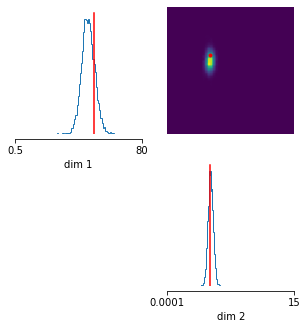

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 76 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

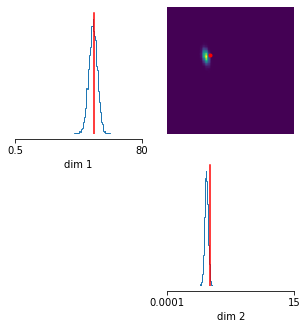

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 39 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

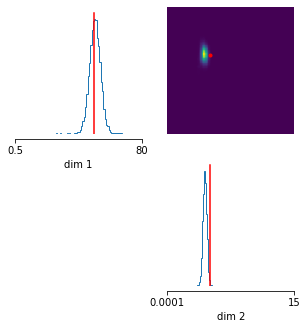

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 55 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

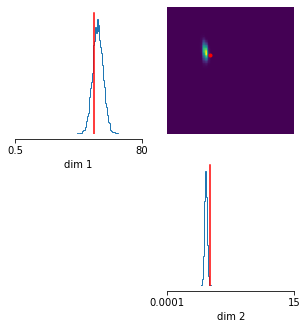

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 45 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

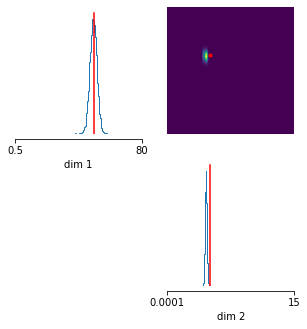

In [145]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_split(120), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(calibration_kernel=filter_kernel(0.5,inference.get_simulations()[1]))
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(torch.zeros(120))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

In [158]:
def simulation_wrapper_hausdorff_split_2(split=7):
    def sim_wrapped(params):
        obs = observation_trace
        data = run_HH_model(params)

        x_pairs = np.array([obs['time'],obs['data']]).T
        y_pairs = np.array([data['time'],data['data']]).T

        x_pairs_split = np.array_split(x_pairs,split)

        summstats = []
        for i in range(split):
            summstats.append(directed_hausdorff(x_pairs_split[i],y_pairs)[0])
        
        return torch.as_tensor(summstats)
    
    return sim_wrapped

def kernel_std_haus_2(xs): # Doesn't work
    
    distances = xs.max(axis=1).values
    var = torch.var(distances)

    def wrapped(x):
        return torch.exp(-0.5*x.max(axis=1).values**2/(var))
    
    return wrapped

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 88 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

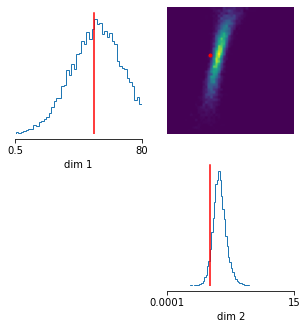

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

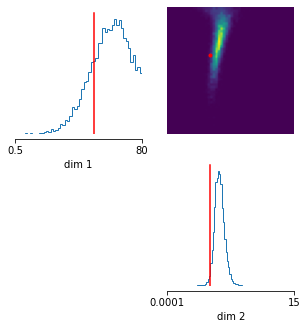

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 84 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

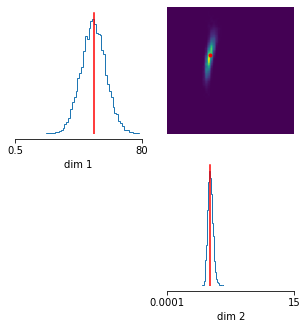

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 59 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

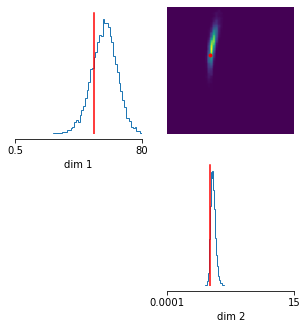

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

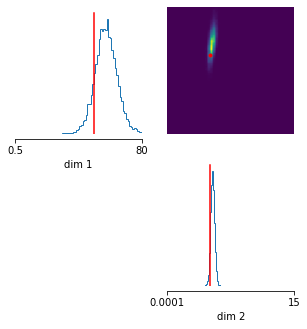

In [159]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_split_2(120), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(calibration_kernel=kernel_std_haus_2(inference.get_simulations()[1]))
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(torch.zeros(120))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

 Neural network successfully converged after 116 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

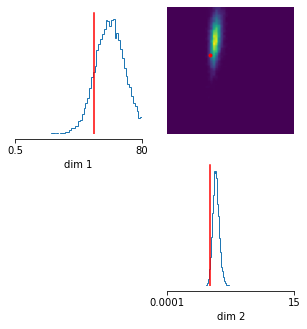

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

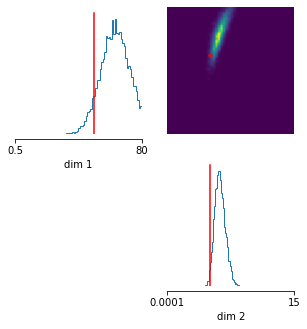

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

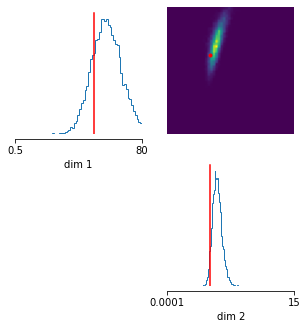

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 86 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

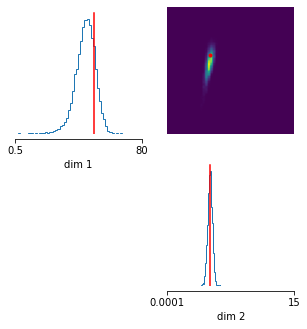

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

Running 200 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

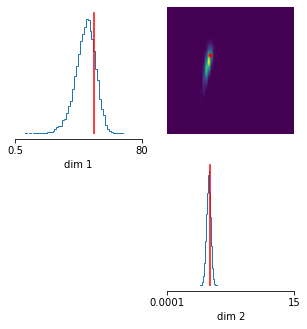

In [162]:
num_rounds = 5
posteriors = []
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_split_2(50), prior)
proposal = prior
inference = SNPE(prior=prior)
for i in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=200, num_workers=7)
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train(calibration_kernel=kernel_std_haus_2(inference.get_simulations()[1]))
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(torch.zeros(50))
    samples = posterior.sample((10000,))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.show()

# Roughs

In [210]:
def effective_sample_size(w):
    """Effective sample size of weights

    `w` is a 1-dimensional tensor of weights (normalised or unnormalised)"""
    sumw = torch.sum(w)
    if sumw == 0:
        return 0.0

    return (sumw ** 2.0) / torch.sum(w ** 2.0)


def get_alternate_weights(sqd, old_weights, eps):
    """Return weights appropriate to another `epsilon` value"""
    # Interpretable version of the generic reweighting code:
    # w = old_weights
    # d = torch.sqrt(sqd)
    # w /= torch.exp(-0.5*(d / old_eps)**2.)
    # w *= torch.exp(-0.5*(d / new_eps)**2.)
    # w /= sum(w)

    w = old_weights.detach().clone()
    if eps == 0:
        # Remove existing distance-based weight contribution
        # Replace with indicator function weight contribution
        w = torch.where(sqd == 0.0, w, torch.zeros_like(w))
    else:
        # An efficient way to do the generic case
        a = -0.5 * eps ** -2.0
        w *= torch.exp(sqd * a)

    sumw = torch.sum(w)
    if sumw > 0.0:
        w /= sumw
    return w


def find_eps(sqd, old_weights, target_ess, upper, bisection_its=50):
    """Return epsilon value <= `upper` giving ess matching `target_ess` as closely as possible

        Bisection search is performed using `bisection_its` iterations
        """
    w = get_alternate_weights(sqd, old_weights, upper)
    ess = effective_sample_size(w)
    if ess < target_ess:
        return upper

    lower = 0.0
    for i in range(bisection_its):
        eps_guess = (lower + upper) / 2.0
        w = get_alternate_weights(sqd, old_weights, eps_guess)
        ess = effective_sample_size(w)
        if ess > target_ess:
            upper = eps_guess
        else:
            lower = eps_guess

    # Consider returning eps=0 if it's still an endpoint
    if lower == 0.0:
        w = get_alternate_weights(sqd, old_weights, 0.0)
        ess = effective_sample_size(w)
        if ess > target_ess:
            return 0.0

    # Be conservative by returning upper end of remaining range
    return upper


In [211]:
def eps_from_x(obs, x, distance_fn, distribution, num_workers, old_epsilon = np.inf):
    distances = Parallel(n_jobs=num_workers, verbose=10)(
        delayed(distance_fn)(data, obs) for data in x
    )
    sqd = torch.tensor(distances) ** 2
    old_log_prob = distribution.log_prob(theta)
    old_weights = np.exp(old_log_prob) / np.exp(old_log_prob).sum()
    if old_epsilon == np.inf:
        upper = torch.max(sqd).item()
    else:
        upper = old_epsilon
    epsilon = find_eps(sqd, old_weights, target_ess=len(x) / 10, upper=upper)
    return epsilon

In [190]:
def kernel_wrapper(x0,distance_fn,epsilon):
    def kernel(x):
        sqd = distance_fn(x0,x)
        val = torch.exp(-0.5*sqd/epsilon**2)
        return val
    return kernel

In [ ]:
def kernel_dynamic(obs, x, distance, distribution, num_workers, old_epsilon = np.inf):


    return

In [231]:
obs = observation_trace
simulator, prior = prepare_for_sbi(simulation_wrapper_euclidean, prior)
inference = SNPE(prior=prior)
proposal = prior
theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100, num_workers=7)
epsilon=eps_from_x(obs, x, euclidean, prior, num_workers=7)
density_estimator = inference.append_simulations(theta, x, proposal=prior).train(calibration_kernel=kernel_wrapper(obs, euclidean, epsilon))
posterior = inference.build_posterior(density_estimator)

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Batch computation too fast (0.0258s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Batch computation too fast (0.0061s.) Setting batch_size=4.


IndexError: too many indices for tensor of dimension 1

In [214]:
kernel_wrapper(observation_trace,euclidean,epsilon)(x[0])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

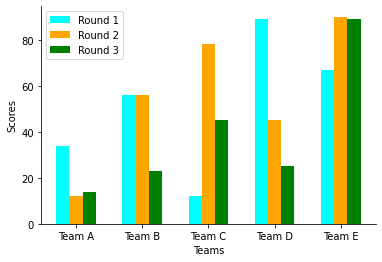

In [295]:
# create data
x = np.arange(5)
y1 = [34, 56, 12, 89, 67]
y2 = [12, 56, 78, 45, 90]
y3 = [14, 23, 45, 25, 89]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')
plt.xticks(x, ['Team A', 'Team B', 'Team C', 'Team D', 'Team E'])
plt.xlabel("Teams")
plt.ylabel("Scores")
plt.legend(["Round 1", "Round 2", "Round 3"])
plt.show()

In [341]:
test1= np.array([1,2,3,4])
test2 = np.array([1,1,5,2])

np.maximum(test1,test2)

array([1, 2, 5, 4])

In [343]:
np.full((7,),5)

array([5, 5, 5, 5, 5, 5, 5])

In [414]:
len(x.sum(axis=1))

200

In [35]:
their_posterior = infer(simulation_wrapper, prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 184 epochs.ural network. Epochs trained: 184

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

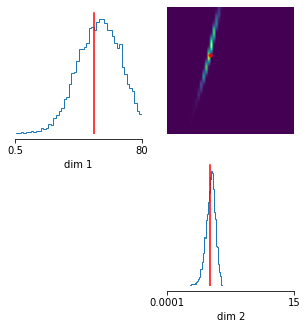

In [42]:
samples = their_posterior.sample((10000,),x=observation_summary_statistics)
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [41]:
our_posterior = infer(simulation_wrapper_euclid_split(200), prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 39 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

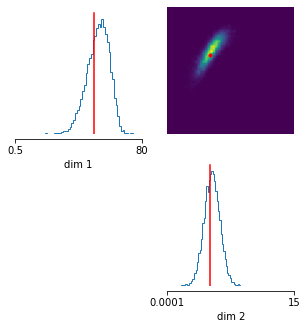

In [45]:
samples = our_posterior.sample((10000,),x=torch.zeros(200))
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [53]:
our_posterior = infer(simulation_wrapper_euclid_split(50), prior, method='SNPE', 
                  num_simulations=300, num_workers=4)

Running 300 simulations in 300 batches.:   0%|          | 0/300 [00:00<?, ?it/s]

 Neural network successfully converged after 64 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

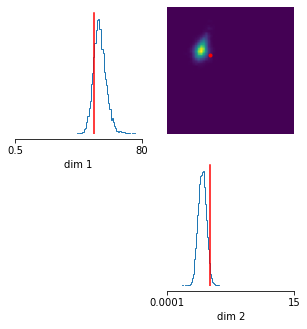

In [54]:
samples = our_posterior.sample((10000,),x=torch.zeros(50))
fig, axes = analysis.pairplot(samples,
                        limits=[[.5,80], [1e-4,15.]],
                        ticks=[[.5,80], [1e-4,15.]],
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [ ]:
bins = [10,20,40,80,160,320]
for i in bins:
    our_posterior = infer(simulation_wrapper_euclid_split(i), prior, method='SNPE', 
                    num_simulations=300, num_workers=4)
    samples = our_posterior.sample((10000,),x=torch.zeros(50))
    fig, axes = analysis.pairplot(samples,
                            limits=[[.5,80], [1e-4,15.]],
                            ticks=[[.5,80], [1e-4,15.]],
                            figsize=(5,5),
                            points=true_params,
                            points_offdiag={'markersize': 6},
                            points_colors='r');
    plt.figure()

In [64]:
simulator, prior = prepare_for_sbi(simulation_wrapper_euclid_split(100),prior)
theta, x = simulate_for_sbi(simulator, proposal, num_simulations=150, num_workers=7)

Drawing 150 posterior samples:   0%|          | 0/150 [00:00<?, ?it/s]

Running 150 simulations in 150 batches.:   0%|          | 0/150 [00:00<?, ?it/s]

In [90]:
len(kernel_std(x)(x))

200

In [102]:

def filter_kernel(quant):
    
    def wrapped(xs):
        xs=samples.sum(axis=1)
        quantile = np.quantile(xs,quant)
        
        return (xs < quantile).float()

    return wrapped


In [146]:
simulator, prior = prepare_for_sbi(simulation_wrapper_hausdorff_split(100),prior)
theta, x = simulate_for_sbi(simulator, proposal, num_simulations=100, num_workers=7)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [155]:
def simulation_wrapper_hausdorff_split_test(split=7):
    def sim_wrapped(params):
        obs = observation_trace
        data = run_HH_model(params)

        x_pairs = np.array([obs['time'],obs['data']]).T
        y_pairs = np.array([data['time'],data['data']]).T

        x_pairs_split = np.array_split(x_pairs,split)
        y_pairs_split = np.array_split(y_pairs,split)

        summstats = []
        for i in range(split):
            summstats.append(directed_hausdorff(x_pairs_split[i],y_pairs)[0])
        summstats.append(directed_hausdorff(x_pairs,y_pairs)[0])

        
        return torch.as_tensor(summstats)
    
    return sim_wrapped